In [28]:
"""
virtual wafer generator

"""

"""
Import dependencies
"""
import os, random, psutil, time, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from tqdm import tqdm

def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len*count/float(total)))
    percents = round(100.0 * count/float(total), 1)
    bar = '='* filled_len + '-'*(bar_len - filled_len)
    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()
    #print('[%s] %s%s ...%s\r' % (bar, percents, '%', status), end='', flush=True)

In [41]:
"""
The following function generates a square 2-dimensional random rough surface f(x,y) with NxN  surface points, 
where rL is the length of the surface side, h is the RMS height and clx and cly are the correlation lengths in x and y. 
"""
def surfgen2D(N, rL, h, cl, plot):

    x = np.linspace(-rL/2, rL/2, N);
    y = np.linspace(-rL/2, rL/2, N)
    
    
    [X,Y] = np.meshgrid(x,y)
    
    #plt.figure()
    #plt.imshow(X)
    #plt.figure()
    #plt.imshow(Y)
    
    #np.random.seed(1)
    Z = h * np.random.randn(N,N); 
    # uncorrelated Gaussian random rough surface distribution 
    #with mean 0 and standard deviation h
                                   
    #Gaussian filter
    F = np.exp(-(X**2/(cl**2/2) + Y**2/(cl**2/2)))

    #exp(-(X.^2/(clx^2/2)+Y.^2/(cly^2/2)));
    
    # correlation of surface using convolution (faltung), inverse
    # Fourier transform and normalizing prefactors
    f = 2/np.sqrt(np.pi) * rL/N/np.sqrt(cl)/np.sqrt(cl) * np.fft.ifft2(np.fft.fft2(Z) * np.fft.fft2(F))
    f = f.real
    
    if(plot == 'y'):
        plt.figure()
        plt.imshow(f, origin="lower", cmap='GnBu')
        plt.xlabel('x coordinate (um)')
        plt.ylabel('y coordinate (um)')
        plt.colorbar()
        plt.margins(1000,0)
        plt.show()
     
    return Z, F, f

In [36]:

nos = 100 #number of monte carlo simulations

sigma_w = 5 # nm # width variations sigma
sigma_h = 2 # nm # thickness variations sigma

cl_w = 200 #microns #correlation length
cl_h = cl_w #microns

die_size = 0.5 #mm #chip size

grid_size = int(np.floor(cl_w/9)) #for a cl of 4.5mm ,grid size of 500 microns as mentioned in the paper [https://www.osapublishing.org/oe/abstract.cfm?uri=oe-25-9-9712]
print(grid_size)

die_pixel_side = int(die_size * (1000/grid_size)) #data points on chip side
die_pixel_total = die_pixel_side**2 #number of data points in a virtual die

22


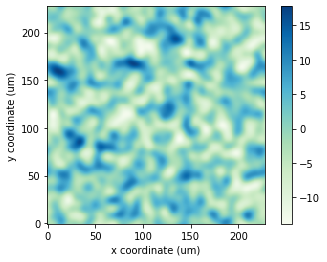

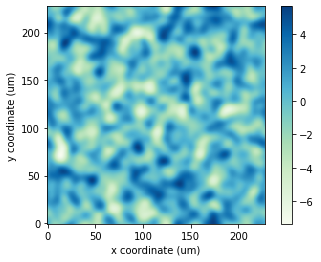

In [43]:
#wafer_pixel_total = die_pixel_total * nos #microns
#wafer_pixel_side = np.sqrt(wafer_pixel_total) #this number needs to round up
#nwafer_pixel_side = np.ceil(wafer_pixel_side/die_pixel_side)*die_pixel_side

#rL = nwafer_pixel_side
#rL = 8000 #multiplier * cl #microns
#N = int(rL)+1#2*int( np.ceil(rL/(multiplier/2))) #number of points

rL = int(np.ceil(np.sqrt(nos*(die_size*1000)**2)/(die_size*1000))*(die_size*1000)) # length of the virtual wafer

N =  int(rL/grid_size)+1#int(nwafer_pixel_side) # number of data points per virtual wafer side 

plot = 'y'

#print(die_size, die_pixel_side, N, rL, cl_w, grid_size)
#print(nwafer_pixel_side, wafer_pixel_side, N)


random_w, filter_w, f_w = surfgen2D(N, rL, sigma_w, cl_w, plot) # generate virtual wafer for width
random_h, filter_h, f_h = surfgen2D(N, rL, sigma_h, cl_h, plot) # generate virtual wafer for thickness

noe = 10  #number of circuit components to sample variations for

#random locations of number of elements
xlocs = [np.random.randint(0, (die_size*1000)+1) for i in range(noe)] 
ylocs = [np.random.randint(0, (die_size*1000)+1) for i in range(noe)] 

#matrix to store interpolated variations for noe components
var_w = np.zeros([nos, noe])
var_h = np.zeros([nos, noe])



In [44]:

#select a die from the generated virtual wafer and sample variations for components

count = 0
with tqdm(total=nos) as pbar:
    for i in range(int(die_pixel_side), N, int(die_pixel_side)):
        for j in range(int(die_pixel_side),N, int(die_pixel_side)):
            pbar.update(1)
            #progress(count, nos)
            #print(i,j)
            if(count < nos):
                wselected_die = f_w[i-die_pixel_side:i,j-die_pixel_side:j]
                wcurr_x = np.linspace(0, die_size*1000 , die_pixel_side)
                wcurr_y = np.linspace(0, die_size*1000, die_pixel_side)
                wfunc = interpolate.interp2d(wcurr_x, wcurr_y, wselected_die, kind='linear')
                wxnew = np.linspace(0, die_size*1000, (die_size*1000)+1)
                wynew = np.linspace(0, die_size*1000, (die_size*1000)+1)
                wfnew = wfunc(wxnew, wynew)
    
                hselected_die = f_h[i-die_pixel_side:i,j-die_pixel_side:j]
                hcurr_x = np.linspace(0, die_size*1000 , die_pixel_side)
                hcurr_y = np.linspace(0, die_size*1000, die_pixel_side)
                hfunc = interpolate.interp2d(hcurr_x, hcurr_y, hselected_die, kind='linear')
                hxnew = np.linspace(0, die_size*1000, (die_size*1000)+1)
                hynew = np.linspace(0, die_size*1000, (die_size*1000)+1)
                hfnew = hfunc(hxnew, hynew)
                
                for each_component in range(noe):
                    temp_x = xlocs[each_component]
                    temp_y = ylocs[each_component]
                    var_w[count, each_component] = wfnew[temp_x, temp_y]
                    var_h[count, each_component] = hfnew[temp_x, temp_y]
                    
                count +=1
            else:
                break
        

print(len(f_w), len(f_h))



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\root\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
C:\Users\root\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()
C:\Users\root\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
C:\Users\root\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 136.92it/s]


228 228
